按患者提取每一段preictal和interictal的数据信息
preictal形如:[[('chb01_03.edf', (896.0, 2696.0))], [('chb01_14.edf', (3239.0, 3600)), ('chb01_15.edf', (0, 1432.0))], [('chb01_15.edf', (2522.0, 3600)), ('chb01_16.edf', (0, 715.0))], [('chb01_17.edf', (3227.0, 3600)), ('chb01_18.edf', (0, 1420.0))], [('chb01_20.edf', (1133.0, 2663)), ('chb01_21.edf', (0, 27.0))], [('chb01_25.edf', (3370.0, 3600)), ('chb01_26.edf', (0, 1562.0))]]
interictal形如:[('chb01_08.edf', (1466.0, 3600)), ('chb01_09.edf', (0, 3600)), ('chb01_10.edf', (0, 3600)), ('chb01_11.edf', (0, 1762.0)), ('chb01_32.edf', (2553.0, 3600)), ('chb01_33.edf', (0, 3600)), ('chb01_34.edf', (0, 3600)), ('chb01_36.edf', (0, 3600)), ('chb01_37.edf', (0, 3600)), ('chb01_38.edf', (0, 3600)), ('chb01_39.edf', (0, 3600)), ('chb01_40.edf', (0, 3600)), ('chb01_41.edf', (0, 3600)), ('chb01_42.edf', (0, 3600)), ('chb01_43.edf', (0, 3600)), ('chb01_46.edf', (0, 3600))]

In [41]:
import json
import re
from pathlib import Path
from typing import List, Dict, Tuple, Optional

DATA_DIR = Path('D:\陈教授组\CHB-MIT')
PATIENT_NUM = 8

def tuple_add(t1, t2):
    """将两个元组的对应元素相加"""
    return tuple(a + b for a, b in zip(t1, t2))

def interval_difference(main_interval, remove_intervals):
    """
    计算一个区间减去多个区间的差集
    
    Args:
        main_interval: 主区间，格式 (start, end)
        remove_intervals: 要移除的区间列表，格式 [(start, end), ...]
    
    Returns:
        差集区间列表，可能为空、一个或多个区间
    """
    if not remove_intervals:
        return [main_interval]
    
    # 初始化结果为整个主区间
    result = [main_interval]
    
    # 逐个移除每个 remove_interval
    for remove_interval in remove_intervals:
        new_result = []
        for interval in result:
            # 对当前结果中的每个区间，减去 remove_interval
            parts = _subtract_two_intervals(interval, remove_interval)
            new_result.extend(parts)  # 添加差集部分
        result = new_result  # 更新结果
    
    # 可选：合并重叠或相邻的区间（如果 remove_intervals 有重叠）
    # 这里我们先不合并，保留所有片段
    return result

def _subtract_two_intervals(interval1, interval2):
    """
    计算两个区间之间的差集（私有辅助函数）
    返回 interval1 - interval2 的结果（列表）
    """
    start1, end1 = interval1
    start2, end2 = interval2
    
    # 计算交集
    inter_start = max(start1, start2)
    inter_end   = min(end1, end2)
    
    # 如果无交集，返回原区间
    if inter_start >= inter_end:
        return [interval1]
    
    parts = []
    if start1 < inter_start:
        parts.append((start1, inter_start))
    if inter_end < end1:
        parts.append((inter_end, end1))
    
    return parts

def interval_union(intervals):
    """
    计算多个区间的并集
    
    Args:
        intervals: 区间列表，每个区间为 (start, end) 元组
    
    Returns:
        合并后的区间列表
    """
    if not intervals:
        return []
    
    # 1. 按起始时间排序
    sorted_intervals = sorted(intervals, key=lambda x: x[0])
    
    # 2. 合并
    union = [sorted_intervals[0]]  # 第一个区间
    
    for current in sorted_intervals[1:]:
        last = union[-1]
        
        # 如果当前区间与上一个区间重叠或相邻
        if current[0] <= last[1]:  # 有重叠
            # 合并：更新上一个区间的结束时间为两者最大值
            new_end = max(last[1], current[1])
            union[-1] = (last[0], new_end)
        else:
            # 无重叠，直接添加
            union.append(current)
    
    return union

def interval_intersection_list(main_interval, intervals):
    """
    计算一个区间与多个区间的交集
    如果只有一个交集，返回元组；否则返回列表
    """
    if not intervals:
        return None  # 或者返回 []
    
    start1, end1 = main_interval
    intersections = []
    
    for interval in intervals:
        start2, end2 = interval
        inter_start = max(start1, start2)
        inter_end   = min(end1, end2)
        
        if inter_start < inter_end:
            intersections.append((inter_start, inter_end))
    
    # 关键：根据数量决定返回类型
    if len(intersections) == 0:
        return None  # 无交集
    elif len(intersections) == 1:
        return intersections[0]  # 返回单个元组
    else:
        return intersections  # 返回列表

def extract_preictals_and_interictals(summary_text: str, 
                                    preictal_duration_minutes: int = 35,
                                    preictal_end_minutes: int = 5,
                                    min_seizure_interval_minutes: int = 40,
                                    excluded_time: int = 240) -> Dict:
    """
    
    Args:
        summary_text: summary文件的文本内容
        preictal_duration_minutes: 预发作期总时长（分钟），默认35分钟
        preictal_end_minutes: 预发作期结束前多少分钟，默认5分钟（即35-5=30分钟有效）
        min_seizure_interval_minutes: 最小发作间隔（分钟），默认40分钟
    
    Returns:
        包含所有预发作期信息的字典
    """
    
    # 解析所有文件信息
    files_info = parse_files_info_fixed(summary_text)
    if not files_info:
        return {}
    
    # 按文件顺序排序（不是按时间，因为文件本身就是按时间顺序的）
    #files_info.sort(key=lambda x: x['filename'])
    print([file_info['filename'] for file_info in files_info])
    # 计算累积时间偏移
    cumulative_offset = 0
    for file_info in files_info:
        file_info['cumulative_start'] = cumulative_offset + file_info['gap_before']
        file_info['cumulative_end'] = file_info['cumulative_start'] + file_info['duration_seconds'] 
        file_info['cumulative_interval'] = (file_info['cumulative_start'], file_info['cumulative_end'])
        cumulative_offset = file_info['cumulative_end']
    total_interval = (0, files_info[-1]['cumulative_end'])
    # 提取所有发作信息（使用累积时间）
    preictal_segments = []
    seizures = extract_seizures_with_cumulative_time(files_info,summary_text)
    if not seizures:
        return {}
    
    # 过滤间隔过短的发作
    filtered_seizures = filter_seizures_by_interval_fixed(seizures, min_seizure_interval_minutes)
    print(filtered_seizures)
    
    # 为每个有效发作生成预发作期
    for i, seizure in enumerate(filtered_seizures, 1):
        preictal_segments.append(generate_preictal_segments_fixed(
            seizure, files_info, preictal_duration_minutes, preictal_end_minutes
        ))

    seizures_time_separate = []
    for seizure in seizures:
        print(seizure['interval_cumulative'])
        seizures_time_separate.append(tuple_add(seizure['interval_cumulative'], (-excluded_time*60,excluded_time*60)))
    print(seizures_time_separate)
    seizures_time = interval_union(seizures_time_separate)
    print(seizures_time)
    interictals_time = interval_difference(total_interval, seizures_time)
    print(interictals_time)
    
    interictal_segments = []
    for file_info in files_info:
        interical_interval = interval_intersection_list(file_info['cumulative_interval'], interictals_time)
        print(interical_interval)
        if interical_interval is not None:
            interictal_segments.append((
                file_info['filename'],
                (interical_interval[0] - file_info['cumulative_start'], interical_interval[1] - file_info['cumulative_start'])
            ))

    return preictal_segments, interictal_segments

def parse_time_to_seconds(time_str: str) -> int:
    """将时间字符串转换为秒数"""
    try:
        parts = time_str.split(':')
        if len(parts) == 3:
            hours, minutes, seconds = map(int, parts)
            return hours * 3600 + minutes * 60 + seconds
        elif len(parts) == 2:
            minutes, seconds = map(int, parts)
            return minutes * 60 + seconds
        else:
            return int(time_str)
    except:
        return 0
        
def parse_files_info_fixed(summary_text: str) -> List[Dict]:
    """解析所有文件的基本信息"""
    files_info = []
    lines = summary_text.strip().split('\n')
    
    current_file = None
    for line in lines:
        line = line.strip()
        
        if line.startswith('File Name:'):
            current_file = line.split(':', 1)[1].strip()
        elif line.startswith('File Start Time:') and current_file:
            start_time_str = line.split(':', 1)[1].strip()
        elif line.startswith('File End Time:') and current_file:
            end_time_str = line.split(':', 1)[1].strip()
            
            # 计算文件时长（秒）
            start_seconds = parse_time_to_seconds(start_time_str)
            end_seconds = parse_time_to_seconds(end_time_str)
            
            # 处理跨夜情况
            if end_seconds < start_seconds:
                end_seconds += 24 * 3600  # 加24小时
                        
            files_info.append({
                'filename': current_file,
                'start_time_str': start_time_str,
                'end_time_str': end_time_str,
                'start_time_seconds': start_seconds,
                'end_time_seconds': end_seconds,
                'duration_seconds': end_seconds - start_seconds
            })
            current_file = None

    files_info[0]['gap_before'] = 0
            
    for i in range(1, len(files_info)):
        prev_file = files_info[i - 1]
        curr_file = files_info[i]
                
        # 获取前一个文件的结束时间和当前文件的开始时间（真实时间轴）
        prev_end_time = prev_file['end_time_seconds']
        curr_start_time = curr_file['start_time_seconds']
                
        # 处理跨夜情况
        if curr_start_time < prev_end_time:
            curr_start_time += 24 * 3600  # 加24小时
                
        # 计算真实时间间隔（秒）
        gap_seconds = curr_start_time - prev_end_time
                
        # 确保间隔非负
        gap_seconds = max(0, gap_seconds)
                
        # 记录间隔
        curr_file['gap_before'] = gap_seconds
                  
    return files_info


def extract_seizures_with_cumulative_time(files_info: List[Dict], summary_text) -> List[Dict]:
    """从文件信息中提取所有发作，使用累积时间"""
    seizures = []
    lines = summary_text.strip().split('\n')
    
    current_file = None
    current_file_info = None
    
    for line in lines:
        line = line.strip()
        
        if line.startswith('File Name:'):
            current_file = line.split(':', 1)[1].strip()
            current_file_info = next((f for f in files_info if f['filename'] == current_file), None)
        elif 'Seizure' in line and 'Start Time:' in line and current_file and current_file_info:
            try:
                seizure_start_in_file = float(line.split(':', 1)[1].strip().split()[0])
                seizure_start_cumulative = current_file_info['cumulative_start'] + seizure_start_in_file
                seizures.append({
                    'filename': current_file,
                    'start_in_file': seizure_start_in_file,
                    'start_cumulative': seizure_start_cumulative,
                    'end_in_file': None,
                    'end_cumulative': None
                })
            except (ValueError, IndexError):
                continue
        elif 'Seizure' in line and 'End Time:' in line and current_file and current_file_info and seizures:
            try:
                seizure_end_in_file = float(line.split(':', 1)[1].strip().split()[0])
                seizure_end_cumulative = current_file_info['cumulative_start'] + seizure_end_in_file
                seizures[-1]['end_in_file'] = seizure_end_in_file
                seizures[-1]['end_cumulative'] = seizure_end_cumulative
                seizures[-1]['interval_cumulative'] = (seizures[-1]['start_cumulative'], seizures[-1]['end_cumulative'])
            except (ValueError, IndexError):
                continue
    print(seizures)
    return seizures

def filter_seizures_by_interval_fixed(seizures: List[Dict], min_interval_minutes: int) -> List[Dict]:
    """过滤间隔过短的发作"""
    if not seizures:
        return []
    
    filtered = [seizures[0]]  # 保留第一个发作
    
    for i in range(1, len(seizures)):
        prev_seizure = seizures[i-1]
        curr_seizure = seizures[i]
        
        # 计算间隔（分钟）
        interval_minutes = (curr_seizure['start_cumulative'] - prev_seizure['end_cumulative']) / 60
        
        if interval_minutes >= min_interval_minutes:
            filtered.append(curr_seizure)
    
    return filtered

def interval_intersection(interval1: tuple, interval2: tuple) -> tuple:
    """
    计算两个区间的交集
    
    Args:
        interval1: 第一个区间，格式 (start, end)
        interval2: 第二个区间，格式 (start, end)
    
    Returns:
        交集区间 (start, end)，如果没有交集，返回 None 或空元组
    """
    start1, end1 = interval1
    start2, end2 = interval2
    
    # 计算交集的起始和结束
    intersection_start = max(start1, start2)
    intersection_end   = min(end1, end2)
    
    # 如果起始 >= 结束，说明无交集
    if intersection_start < intersection_end:
        return (intersection_start, intersection_end)
    else:
        return None  # 或者返回 ()

def generate_preictal_segments_fixed(seizure: Dict, files_info: List[Dict], 
                                    preictal_duration_minutes: int, preictal_end_minutes: int) -> List[Tuple]:
    """为单个发作生成预发作期段（修复版）"""
    segments = []
    
    # 计算预发作期的累积时间范围
    seizure_start_cumulative = seizure['start_cumulative']
    print(seizure_start_cumulative)
    preictal_start_cumulative = seizure_start_cumulative - (preictal_duration_minutes * 60)
    preictal_end_cumulative = seizure_start_cumulative - (preictal_end_minutes * 60)
    
    # 确保预发作期不早于第一个文件开始
    first_file_start = files_info[0]['cumulative_start']
    print(first_file_start)
    if preictal_start_cumulative < first_file_start:
        print('有数据在第一个文件之前。')
        preictal_start_cumulative = first_file_start
    
    # 如果调整后的预发作期太短，则跳过
    if preictal_end_cumulative <= preictal_start_cumulative:
        print('无效数据。')
        return segments
    
    preictal_time_interval = (preictal_start_cumulative,preictal_end_cumulative)

    for file_info in files_info:
        segment_interval = interval_intersection(file_info['cumulative_interval'],preictal_time_interval)
        if segment_interval is not None:
            segments.append((
                file_info['filename'],
                (segment_interval[0] - file_info['cumulative_start'], segment_interval[1] - file_info['cumulative_start'])
            ))
      
    return segments

# 测试修复版函数
def data_splitting():
    """测试修复版预发作期提取"""
    summary_path = DATA_DIR / f'chb{PATIENT_NUM:02d}' / f'chb{PATIENT_NUM:02d}-summary.txt'
        
    if summary_path.exists():
        with open(summary_path, 'r', encoding='utf-8', errors='ignore') as f:
            summary_text = f.read()
            
        preictals, interictals = extract_preictals_and_interictals(summary_text)
        print(preictals)
        print(interictals)
        return preictals, interictals

    else:
        print(f"未找到文件: {summary_path}")

# 运行测试
preictals, interictals = data_splitting()



['chb08_02.edf', 'chb08_03.edf', 'chb08_04.edf', 'chb08_05.edf', 'chb08_10.edf', 'chb08_11.edf', 'chb08_12.edf', 'chb08_13.edf', 'chb08_14.edf', 'chb08_15.edf', 'chb08_16.edf', 'chb08_17.edf', 'chb08_18.edf', 'chb08_19.edf', 'chb08_20.edf', 'chb08_21.edf', 'chb08_22.edf', 'chb08_23.edf', 'chb08_24.edf', 'chb08_29.edf']
[{'filename': 'chb08_02.edf', 'start_in_file': 2670.0, 'start_cumulative': 2670.0, 'end_in_file': 2841.0, 'end_cumulative': 2841.0, 'interval_cumulative': (2670.0, 2841.0)}, {'filename': 'chb08_05.edf', 'start_in_file': 2856.0, 'start_cumulative': 13673.0, 'end_in_file': 3046.0, 'end_cumulative': 13863.0, 'interval_cumulative': (13673.0, 13863.0)}, {'filename': 'chb08_11.edf', 'start_in_file': 2988.0, 'start_cumulative': 32272.0, 'end_in_file': 3122.0, 'end_cumulative': 32406.0, 'interval_cumulative': (32272.0, 32406.0)}, {'filename': 'chb08_13.edf', 'start_in_file': 2417.0, 'start_cumulative': 38916.0, 'end_in_file': 2577.0, 'end_cumulative': 39076.0, 'interval_cumulati

根据上一步的数据信息提取实际的数据

In [42]:
import pyedflib
import numpy as np
from pathlib import Path
from typing import List, Tuple, Optional

# 假设这是您提供的预发作期和间歇期信息
preictal_segments = preictals
interictal_segments = interictals

# 数据集根目录 (请根据您的实际情况修改)
DATA_ROOT = Path(f'D:\陈教授组\CHB-MIT\chb{PATIENT_NUM:02d}')  # 注意使用 raw string 或双反斜杠

# 定义您要保留的通道列表
TARGET_CHANNELS = [
    'C3-P3', 'C4-P4', 'CZ-PZ', 'F3-C3', 'F4-C4', 'F7-T7', 'F8-T8', 'FP1-F3', 'FP1-F7', 'FP2-F4',
    'FP2-F8', 'FT10-T8', 'FT9-FT10', 'FZ-CZ', 'P3-O1', 'P4-O2', 'P7-O1', 'P7-T7', 'P8-O2', 'T7-FT9',
    'T7-P7', 'T8-P8'
]


def read_edf_segment(
    file_path: Path,
    start_sec: float,
    end_sec: float,
    target_channels: List[str]
) -> Tuple[Optional[np.ndarray], List[str], float, List[str]]:
    """
    从EDF文件中读取指定时间段的数据，并筛选指定通道，去除重复项。

    Args:
        file_path: .edf 文件的路径
        start_sec: 起始时间 (秒)
        end_sec: 结束时间 (秒)
        target_channels: 用户指定的目标通道列表。

    Returns:
        (data, final_channels, sample_rate, removed_channels)
        data: 形状为 (n_channels, n_samples) 的numpy数组，如果未找到任何目标通道则为None
        final_channels: 最终保留的通道名称列表（已去重）
        sample_rate: 采样率 (Hz)
        removed_channels: 被移除的重复通道列表
    """
    with pyedflib.EdfReader(str(file_path)) as f:
        sample_rate = f.getSampleFrequency(0)
        all_file_channels = f.getSignalLabels()

        # 找出文件中存在且在目标列表中的通道
        common_channels = [ch for ch in target_channels if ch in all_file_channels]

        if not common_channels:
            print(f"  文件 {file_path.name} 中未找到任何目标通道。")
            return None, [], sample_rate, []

        # 去重，保持顺序
        seen = set()
        final_channels = []
        removed_duplicates = []
        for ch in common_channels:
            if ch in seen:
                removed_duplicates.append(ch)
            else:
                seen.add(ch)
                final_channels.append(ch)

        if removed_duplicates:
            print(f"  在文件 {file_path.name} 中检测到并移除了重复通道: {removed_duplicates}")

        # 计算样本索引
        start_sample = int(start_sec * sample_rate)
        end_sample = int(end_sec * sample_rate)

        # 读取数据
        data = np.vstack([
            f.readSignal(all_file_channels.index(ch), start_sample, end_sample - start_sample)
            for ch in final_channels
        ])

        return data, final_channels, sample_rate, removed_duplicates


def process_segments(segment_list: List, data_label: str):
    """
    处理 preictal 或 interictal 段。
    支持两种结构：
        - preictal: [[('f1',(s,e)), ('f2',(s,e))], ...] → 每个元组是一段
        - interictal: [('f1',(s,e)), ('f2',(s,e)), ...] → 每个元组是一段

    所有段独立处理，不合并。

    Returns:
        all_data: 每个有效段都作为一个独立项加入结果列表
    """
    all_data = []
    global_segment_index = 0  # 用于全局编号

    for i, segment in enumerate(segment_list):
        # 统一展开成 file-time 对列表
        if isinstance(segment, list):
            if len(segment) == 0:
                continue
            if isinstance(segment[0], tuple) and isinstance(segment[0][1], tuple):
                # 情况1: segment 是列表，如 [('f1', (s,e)), ('f2', (s,e))]
                file_time_pairs = segment
            else:
                continue
        elif isinstance(segment, tuple) and isinstance(segment[1], tuple):
            # 情况2: segment 是单个元组，如 ('f1', (s,e))
            file_time_pairs = [segment]
        else:
            continue

        # 现在 file_time_pairs 是 [(), (), ...]，每个元组是一段
        for file_name, (start_sec, end_sec) in file_time_pairs:
            global_segment_index += 1
            print(f"正在处理第 {global_segment_index} 个 {data_label} 段: {file_name} ({start_sec:.1f} - {end_sec:.1f}s)")

            file_path = DATA_ROOT / file_name
            if not file_path.exists():
                print(f"  警告: 文件 {file_path} 不存在，跳过...")
                continue

            try:
                data_segment, channels, sample_rate, removed = read_edf_segment(
                    file_path, start_sec, end_sec, TARGET_CHANNELS
                )

                if data_segment is None:
                    print(f"  文件 {file_name} 中无有效目标通道，跳过此时间段。")
                    continue

                duration = data_segment.shape[1] / sample_rate

                print(f"  读取成功: 形状 {data_segment.shape}, 时长 {duration:.1f}s, "
                      f"保留 {len(channels)} 个通道")
                if removed:
                    print(f"  移除重复通道: {list(set(removed))}")

                all_data.append({
                    'data': data_segment,
                    'channels': channels,
                    'sample_rate': sample_rate,
                    'duration_seconds': duration,
                    'file': file_name,
                    'start_sec': start_sec,
                    'end_sec': end_sec
                })

            except Exception as e:
                print(f"  读取 {file_name} 时出错: {e}")
                continue

            print("-" * 60)

    print(f"\n✅ 总共成功提取了 {len(all_data)} 个独立的 {data_label} 段。\n")
    return all_data


# ========================
# 主处理流程
# ========================

# 处理 preictal 数据（完全保留原逻辑）
print("🚀 开始处理 preictal (预发作期) 数据...\n")
all_preictal_data = process_segments(preictal_segments, "preictal")

# 处理 interictal 数据（新增）
print("🚀 开始处理 interictal (间歇期) 数据...\n")
all_interictal_data = process_segments(interictal_segments, "interictal")

# 最终结果
print("=" * 60)
print("✅ 所有数据处理完成！")
print(f"成功提取 preictal 段数: {len(all_preictal_data)}")
print(f"成功提取 interictal 段数: {len(all_interictal_data)}")

🚀 开始处理 preictal (预发作期) 数据...

正在处理第 1 个 preictal 段: chb08_02.edf (570.0 - 2370.0s)
  读取成功: 形状 (22, 460800), 时长 1800.0s, 保留 22 个通道
------------------------------------------------------------
正在处理第 2 个 preictal 段: chb08_05.edf (756.0 - 2556.0s)
  读取成功: 形状 (22, 460800), 时长 1800.0s, 保留 22 个通道
------------------------------------------------------------
正在处理第 3 个 preictal 段: chb08_11.edf (888.0 - 2688.0s)
  读取成功: 形状 (22, 460800), 时长 1800.0s, 保留 22 个通道
------------------------------------------------------------
正在处理第 4 个 preictal 段: chb08_13.edf (317.0 - 2117.0s)
  读取成功: 形状 (22, 460800), 时长 1800.0s, 保留 22 个通道
------------------------------------------------------------
正在处理第 5 个 preictal 段: chb08_20.edf (3591.0 - 3600.0s)
  读取成功: 形状 (22, 2304), 时长 9.0s, 保留 22 个通道
------------------------------------------------------------
正在处理第 6 个 preictal 段: chb08_21.edf (0.0 - 1783.0s)
  读取成功: 形状 (22, 456448), 时长 1783.0s, 保留 22 个通道
------------------------------------------------------------

✅ 总共成功提取了

通过公式计算preictal的滑动窗口步长，进行样本分割（5s），使得preictal数据量和interictal相似，解决数据不平衡问题

In [43]:
import numpy as np

# 设置采样窗口和通道数
S = 5  # 秒
CHANNEL_NUM = 22  # 通道数

# 统计 preictal 和 interictal 的总时长（秒），合并所有段
M = sum([d['duration_seconds'] for d in all_preictal_data])
N = sum([d['duration_seconds'] for d in all_interictal_data])

# 计算比例 K
K = M / N if N > 0 else 1
'''
print(f"所有 preictal 段总时长 M: {M:.2f} 秒")
print(f"所有 interictal 段总时长 N: {N:.2f} 秒")
print(f"窗口长度 S: {S} 秒")
print(f"步长比例 K: {K:.4f}")
'''
K_DETERMINED = 0.5  # 强制设置 K=0.5

import h5py
import numpy as np
import os

# 确保保存目录存在
save_dir = f"D:\\陈教授组\\mymodel\\data"
os.makedirs(save_dir, exist_ok=True)

# 构建保存路径（使用 .h5 扩展名）
save_path_preictal = f"{save_dir}\\unprocessed\\preictal\\preictal_fragments{PATIENT_NUM:02d}.h5"
save_path_interictal = f"{save_dir}\\unprocessed\\interictal\\interictal_fragments{PATIENT_NUM:02d}.h5"

# 分割并保存 preictal 片段
with h5py.File(save_path_preictal, 'w') as f:
    total_preictal_sample = 0
    for seg_idx, seg in enumerate(all_preictal_data, 1):
        preictal_list = []
        data = seg['data']  # shape: (channels, timepoints)
        sample_rate = seg['sample_rate']
        total_points = data.shape[1]
        window_points = int(S * sample_rate)
        step_points = int(S * K_DETERMINED * sample_rate)
        # 只保留前22通道
        data = data[:CHANNEL_NUM, :]
        # 计算片段数
        a = int(np.floor((data.shape[1] - window_points) / step_points) + 1)
        total_preictal_sample += a
        for i in range(a):
            start = i * step_points
            end = start + window_points
            if end > total_points:
                break
            frag = data[:, start:end]
            preictal_list.append(frag)
        preictal_fragments = np.stack(preictal_list, axis = 0)
        f.create_dataset(f'fragment_{seg_idx:02d}', data=preictal_fragments, compression='gzip')
        print(f"preictal文件 {seg['file']} 形状：{preictal_fragments.shape}")
    print(f"所有 preictal 段总样本数: {total_preictal_sample}")

# 分割 interictal 段
with h5py.File(save_path_interictal, 'w') as f:
    total_interictal_sample = 0
    for seg_idx, seg in enumerate(all_interictal_data, 1):
        interictal_list = []
        data = seg['data']
        sample_rate = seg['sample_rate']
        total_points = data.shape[1]
        window_points = int(S * sample_rate)
        step_points = int(S * sample_rate)
        data = data[:CHANNEL_NUM, :]
        b = int(np.floor((data.shape[1] - window_points) / step_points) + 1)
        total_interictal_sample += b
        for i in range(b):
            start = i * step_points
            end = start + window_points
            if end > total_points:
                break
            frag = data[:, start:end]
            interictal_list.append(frag)
        interictal_fragments = np.stack(interictal_list, axis = 0)
        f.create_dataset(f'fragment_{seg_idx:02d}', data=interictal_fragments, compression='gzip')
        print(f"interictal文件 {seg['file']} 形状：{interictal_fragments.shape}")
    print(f"所有 interictal 段总样本数: {total_interictal_sample}")

print(f"Patient {PATIENT_NUM:02d} 数据已保存为 HDF5 格式：")
print(f"  Preictal: {save_path_preictal}")
print(f"  Interictal: {save_path_interictal}")



preictal文件 chb08_02.edf 形状：(719, 22, 1280)
preictal文件 chb08_05.edf 形状：(719, 22, 1280)
preictal文件 chb08_11.edf 形状：(719, 22, 1280)
preictal文件 chb08_13.edf 形状：(719, 22, 1280)
preictal文件 chb08_20.edf 形状：(2, 22, 1280)
preictal文件 chb08_21.edf 形状：(712, 22, 1280)
所有 preictal 段总样本数: 3590
interictal文件 chb08_29.edf 形状：(724, 22, 1280)
所有 interictal 段总样本数: 724
Patient 08 数据已保存为 HDF5 格式：
  Preictal: D:\陈教授组\mymodel\data\unprocessed\preictal\preictal_fragments08.h5
  Interictal: D:\陈教授组\mymodel\data\unprocessed\interictal\interictal_fragments08.h5


In [7]:
series_list = []

In [44]:
import pandas as pd
data = pd.Series({
    'Patient_Number': PATIENT_NUM,
    'Preictal_Time_Duration': round(M,2) ,
    'Interictal_Time_Duration': round(N,2),
    'Theoretical_Step_Length_Ratio': round(K,4),
    'Determined_Step_Length_Ratio': K_DETERMINED,
    'Total_Preictal_Samples': total_preictal_sample,
    'Total_Interictal_Samples': total_interictal_sample
})
series_list.append(data)


In [45]:
print(series_list)

[Patient_Number                       1.0000
Preictal_Time_Duration           10528.0000
Interictal_Time_Duration         51743.0000
Theoretical_Step_Length_Ratio        0.2035
Determined_Step_Length_Ratio         0.5000
Total_Preictal_Samples            4197.0000
Total_Interictal_Samples         10347.0000
dtype: float64, Patient_Number                       2.0000
Preictal_Time_Duration            5400.0000
Interictal_Time_Duration         93759.0000
Theoretical_Step_Length_Ratio        0.0576
Determined_Step_Length_Ratio         0.5000
Total_Preictal_Samples            2157.0000
Total_Interictal_Samples         18751.0000
dtype: float64, Patient_Number                       3.000
Preictal_Time_Duration           10358.000
Interictal_Time_Duration         98620.000
Theoretical_Step_Length_Ratio        0.105
Determined_Step_Length_Ratio         0.500
Total_Preictal_Samples            4131.000
Total_Interictal_Samples         19723.000
dtype: float64, Patient_Number                    

In [ ]:
data_table = pd.concat(series_list, axis=1).T

对每一个样本进行STFT变换

In [ ]:



import torch

# 参数配置
n_fft = 256
win_length = 256
hop_length = 64
window = torch.hann_window(256)
center = True
return_complex = True

# 假设每个片段的 shape: (通道数, 时间点数)
def apply_stft_to_array(data_array):
    """
    对三维数组应用STFT变换
    输入: (样本数, 通道数, 时间点数)
    输出: (样本数, 通道数, 频率bins, 时间frames)
    """
    if data_array.size == 0:
        return np.array([])
    
    n_samples, n_channels, n_timepoints = data_array.shape
    stft_list = []
    
    for sample_idx in range(n_samples):
        sample_data = data_array[sample_idx]  # (通道数, 时间点数)
        # 转为 torch tensor，float32
        sample_tensor = torch.tensor(sample_data, dtype=torch.float32)
        # 对每个通道分别做 stft
        stft_channels = []
        for ch in range(n_channels):
            stft_result = torch.stft(
                sample_tensor[ch],
                n_fft=n_fft,
                hop_length=hop_length,
                win_length=win_length,
                window=window,
                center=center,
                return_complex=return_complex
            )  # shape: (freq_bins, time_frames)
            stft_channels.append(stft_result)
        # 堆叠成 (channels, freq_bins, time_frames)
        stft_sample = torch.stack(stft_channels, dim=0)
        stft_list.append(stft_sample)
    
    # 堆叠所有样本 (样本数, 通道数, freq_bins, time_frames)
    return torch.stack(stft_list, dim=0)

# 对 preictal 和 interictal 数组列表分别做 STFT
stft_preictal_arrays = []
for file_idx, filtered_array in enumerate(filtered_preictal_arrays):
    stft_array = apply_stft_to_array(filtered_array)
    stft_preictal_arrays.append(stft_array)
    print(f"preictal文件段{file_idx+1} STFT后形状: {stft_array.shape}")

stft_interictal_arrays = []
for file_idx, filtered_array in enumerate(filtered_interictal_arrays):
    stft_array = apply_stft_to_array(filtered_array)
    stft_interictal_arrays.append(stft_array)
    print(f"interictal文件段{file_idx+1} STFT后形状: {stft_array.shape}")

print(f"\n总共有 {len(stft_preictal_arrays)} 个preictal文件段的STFT数据")
print(f"总共有 {len(stft_interictal_arrays)} 个interictal文件段的STFT数据")


STFT 后 preictal_fragments 示例形状： [torch.Size([22, 129, 21]), torch.Size([22, 129, 21]), torch.Size([22, 129, 21])]
STFT 后 interictal_fragments 示例形状： [torch.Size([22, 129, 21]), torch.Size([22, 129, 21]), torch.Size([22, 129, 21])]


可视化

C:\Users\Administrator\AppData\Local\Temp\ipykernel_7920\182502566.py:24: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(bins, freqs, 10 * np.log10(preictal_Pxx), shading="gouraud", cmap="jet")
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7920\182502566.py:29: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7920\182502566.py:29: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7920\182502566.py:29: UserWarning: Glyph 31186 (\N{CJK UNIFIED IDEOGRAPH-79D2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7920\182502566.py:29: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local

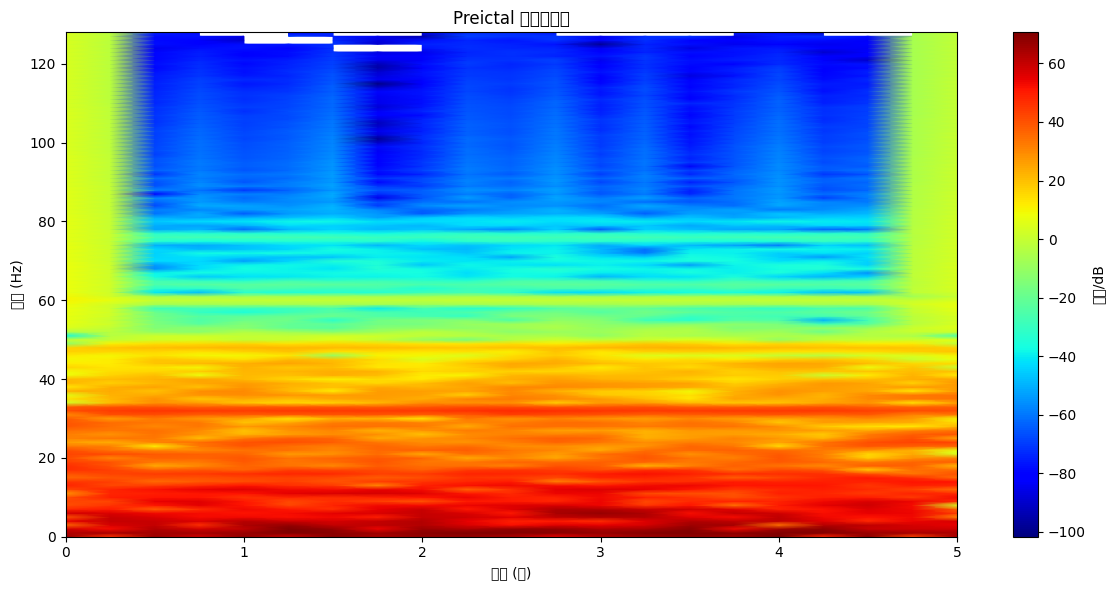

C:\Users\Administrator\AppData\Local\Temp\ipykernel_7920\182502566.py:36: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(bins, freqs, 10 * np.log10(interictal_Pxx), shading="gouraud", cmap="jet")
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7920\182502566.py:41: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7920\182502566.py:41: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7920\182502566.py:41: UserWarning: Glyph 31186 (\N{CJK UNIFIED IDEOGRAPH-79D2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7920\182502566.py:41: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Loc

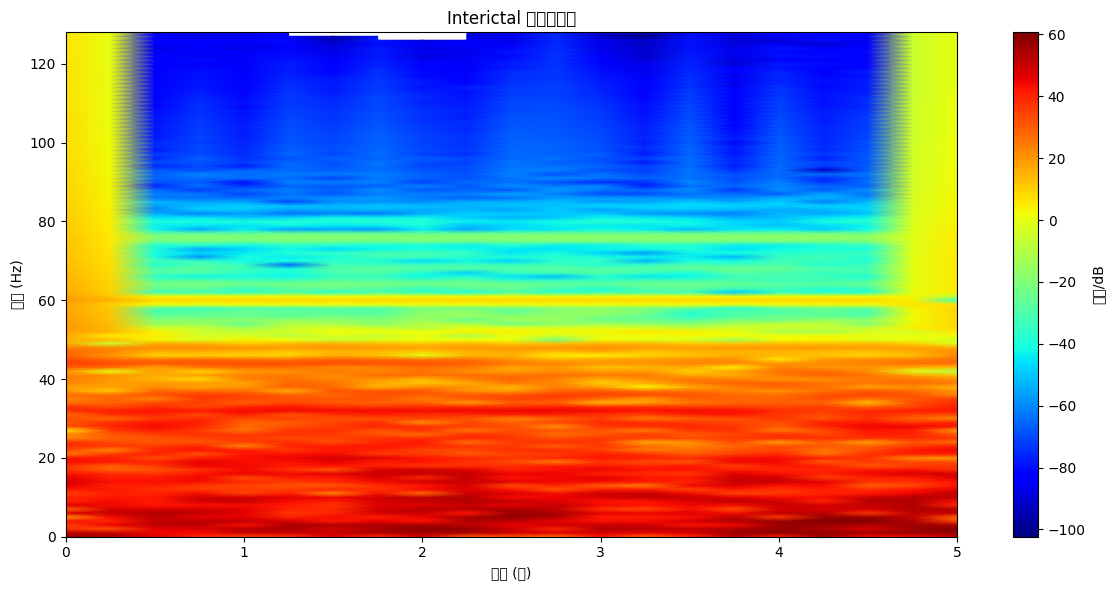

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

# 选择一个 preictal 和一个 interictal 样本进行可视化
sample_idx = 0  # 可以根据需要更换索引

if len(stft_preictal_arrays) > 0 and len(stft_interictal_arrays) > 0:
    # 选择第一个文件段的第一个样本
    preictal_spec = stft_preictal_arrays[0][sample_idx]  # shape: (channels, freq_bins, time_frames)
    # 选择第一个文件段的第一个样本
    interictal_spec = stft_interictal_arrays[0][sample_idx]

    # 只可视化第一个通道
    preictal_ch_spec = preictal_spec[0]  # [freq_bins, time_frames]
    interictal_ch_spec = interictal_spec[0]

    # 转为 numpy 并取幅值的平方（功率谱）
    preictal_Pxx = preictal_ch_spec.abs().numpy() ** 2
    interictal_Pxx = interictal_ch_spec.abs().numpy() ** 2

    # 计算频率和时间轴
    sr = 256  # 采样率
    freqs = np.linspace(0, sr // 2, preictal_Pxx.shape[0])
    bins = np.arange(preictal_Pxx.shape[1]) * hop_length / sr

    # 绘制 preictal 样本
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(bins, freqs, 10 * np.log10(preictal_Pxx), shading="gouraud", cmap="jet")
    plt.colorbar(label="功率/dB")
    plt.xlabel('时间 (秒)')
    plt.ylabel('频率 (Hz)')
    plt.title('Preictal 样本时频图')
    plt.tight_layout()
    plt.show()

    # 绘制 interictal 样本
    freqs = np.linspace(0, sr // 2, interictal_Pxx.shape[0])
    bins = np.arange(interictal_Pxx.shape[1]) * hop_length / sr
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(bins, freqs, 10 * np.log10(interictal_Pxx), shading="gouraud", cmap="jet")
    plt.colorbar(label="功率/dB")
    plt.xlabel('时间 (秒)')
    plt.ylabel('频率 (Hz)')
    plt.title('Interictal 样本时频图')
    plt.tight_layout()
    plt.show()
else:
    print("没有足够的数据进行可视化")